# Laboratorium 1: Symulacje deterministyczne

**Imię i nazwisko:** Anna Bernard, Mikołaj Mieszko Charchuta 
**Grupa:**  Symulanci
**Data wykonania:**  18.05.2025

---

## 1. Wstęp

W tym sprawozdaniu przedstawiono implementację algorytmu Rungego-Kutty IV rzędu (RK4) oraz RK45 (IV rzędu z krokiem korygowanym rzędem V) oraz wyniki symulacji modelu matematycznego sieci interakcji biochemicznych w czterech scenariuszach stanu komórki.

## 2. Opis zaimplementowanego rozwiązania

- **Wariant implementacji:** RK4 ze stałym krokiem oraz RK45 ze zmiennym krokiem
- **Biblioteki użyte:** numpy, matplotlib
- **Model:** Symulacja dynamiki białek p53, MDMcyto, MDMn, PTEN w czterech scenariuszach biologicznych
- **Horyzont czasowy:** 48 godzin (2880 minut)
- **Krok całkowania:** 6 minut
- **Wprowadzanie danych:** Ręczne w terminalu lub przyjęcie domyślnych

### Źródła przyjętych stężeń

#### 1. **p53**
- **Stężenie:** ~10–100 nM (w komórkach niepoddanych stresowi; silnie zmienne w zależności od typu komórki i warunków)
- **Literatura:**
    - Purvis et al. (2012), _"p53 dynamics control cell fate." Science, 336(6087), 1440-1444._ [DOI: 10.1126/science.1218351](https://doi.org/10.1126/science.1218351)
    - Batchelor et al. (2011), _"Stimulus-dependent dynamics of p53 in single cells." Molecular Systems Biology, 7, 488._ [DOI: 10.1038/msb.2011.20](https://doi.org/10.1038/msb.2011.20)

#### 2. **MDM2 (MDMcyto – cytoplazmatyczny MDM2)**
- **Stężenie:** ~50–200 nM (wyższe w komórkach nowotworowych)
- **Literatura:**
    - Lahav et al. (2004), _"Dynamics of the p53-MDM2 feedback loop in individual cells." Nature Genetics, 36(2), 147-150._ [DOI: 10.1038/ng1293](https://doi.org/10.1038/ng1293)

#### 3. **MDM2 (MDMn – jądrowy MDM2)**
- **Stężenie:** Podobne do cytoplazmatycznego MDM2 (~50–200 nM), ale poziomy jądrowe mogą się wahać w wyniku regulacji przez p53
- **Literatura:**
    - Geva-Zatorsky et al. (2006), _"Oscillations and variability in the p53 system." Molecular Systems Biology, 2, 2006.0033._ [DOI: 10.1038/msb4100068](https://doi.org/10.1038/msb4100068)

#### 4. **PTEN**
- **Stężenie:** ~100–500 nM (różni się w zależności od tkanki; niższe w niektórych nowotworach z powodu haploinsuficjencji)
- **Literatura:**
    - Leslie et al. (2008), _"The importance of PTEN phosphorylation in vivo." Biochemical Society Transactions, 36(Pt 3), 287-291._ [DOI: 10.1042/BST0360287](https://doi.org/10.1042/BST0360287)
    - Alimonti et al. (2010), _"Subtle variations in PTEN dose determine cancer susceptibility." Nature Genetics, 42(5), 454-458._ [DOI: 10.1038/ng.556](https://doi.org/10.1038/ng.556)

---

**Uwagi:**
- Stężenia mogą się znacznie różnić między typami komórek (np. nowotworowe vs. prawidłowe).
- Poziomy p53 są ściśle regulowane przez degradację zależną od MDM2 i wykazują dynamiczne fluktuacje.
- Poziomy PTEN są często obniżone w nowotworach z powodu utraty jednej kopii genu.
- Kierując się tą wiedzą zalecane byłoby stosowanie różnych warunków początkowych w poszczególnych scenariuszach.


In [26]:
# Importy
import numpy as np
import matplotlib.pyplot as plt

# Parametry modelu
p1 = 8.8
p2 = 440
p3 = 100
d1 = 1.375*(10**-14)
d2 = 1.375*(10**-4)
d3 = 3*(10**-5)
k1 = 1.925*(10**-4)
k2 = 10**5
k3 = 1.5*(10**5)
value_siRNA = 0.02
value_PTEN_off = 0
value_no_DNA_damage = 0.1

def f_p53(p53, mdmn): 
    return p1 - d1*p53*(mdmn**2)

def f_mdmcyto(p53, mdmcyto, pten, siRNA=False, no_DNA_damage=False):
    siRNA_factor = value_siRNA if siRNA else 1
    DNA_damage_factor = value_no_DNA_damage if no_DNA_damage else 1
    return p2*siRNA_factor*(p53**4)/((p53**4) + (k2**4)) - k1*(k3**2)/((k3**2) + (pten**2))*mdmcyto - d2*DNA_damage_factor*mdmcyto

def f_mdmn(mdmn, mdmcyto, pten, no_DNA_damage=False):
    if no_DNA_damage:
        return k1*(k3**2)/((k3**2) + (pten**2))*mdmcyto - d2*value_no_DNA_damage*mdmn
    else:
        return k1*(k3**2)/((k3**2) + (pten**2))*mdmcyto - d2*mdmn

def f_pten(pten, p53, pten_off=False):
    if not pten_off:
        return p3*(p53**4)/((p53**4) + (k2**4)) - d3*pten
    else:
        return p3*value_PTEN_off*(p53**4)/((p53**4) + (k2**4)) - d3*pten

Tu nie ma wiele do wyjaśnienia. Anna napisała to po mistrzowsku i jest przejrzyście i jasno zaimplementowane.

In [27]:
# RK4 ze stałym krokiem
def RK4const(p53, mdcyto, mdmn, pten, h, siRNA=False, pten_off=False, no_DNA_damage=False):
    k1_p53 = f_p53(p53, mdmn)
    k1_mdmcyto = f_mdmcyto(p53, mdcyto, pten, siRNA)
    k1_mdmn = f_mdmn(mdmn, mdcyto, pten)
    k1_pten = f_pten(pten, p53, pten_off)

    k2_p53 = f_p53(p53 + h/2*k1_p53, mdmn + h/2*k1_mdmn)
    k2_mdmcyto = f_mdmcyto(p53 + h/2*k1_p53, mdcyto + h/2*k1_mdmcyto, pten + h/2*k1_pten, siRNA)
    k2_mdmn = f_mdmn(mdmn + h/2*k1_mdmn, mdcyto + h/2*k1_mdmcyto, pten + h/2*k1_pten)
    k2_pten = f_pten(pten + h/2*k1_pten, p53 + h/2*k1_p53, pten_off)

    k3_p53 = f_p53(p53 + h/2*k2_p53, mdmn + h/2*k2_mdmn)
    k3_mdmcyto = f_mdmcyto(p53 + h/2*k2_p53, mdcyto + h/2*k2_mdmcyto, pten + h/2*k2_pten, siRNA)
    k3_mdmn = f_mdmn(mdmn + h/2*k2_mdmn, mdcyto + h/2*k2_mdmcyto, pten + h/2*k2_pten)
    k3_pten = f_pten(pten + h/2*k2_pten, p53 + h/2*k2_p53, pten_off)

    k4_p53 = f_p53(p53 + h*k3_p53, mdmn + h*k3_mdmn)
    k4_mdmcyto = f_mdmcyto(p53 + h*k3_p53, mdcyto + h*k3_mdmcyto, pten + h*k3_pten, siRNA)
    k4_mdmn = f_mdmn(mdmn + h*k3_mdmn, mdcyto + h*k3_mdmcyto, pten + h*k3_pten)
    k4_pten = f_pten(pten + h*k3_pten, p53 + h*k3_p53,  pten_off)

    p53 += (k1_p53 + 2*k2_p53 + 2*k3_p53 + k4_p53) * h / 6
    mdcyto += (k1_mdmcyto + 2*k2_mdmcyto + 2*k3_mdmcyto + k4_mdmcyto) * h / 6
    mdmn += (k1_mdmn + 2*k2_mdmn + 2*k3_mdmn + k4_mdmn) * h / 6
    pten += (k1_pten + 2*k2_pten + 2*k3_pten + k4_pten) * h / 6
    return p53, mdcyto, mdmn, pten

To moje autorskie rozwiązanie, krok jest modyfikowany aż do skutku.

In [28]:
# RK45 ze zmiennym krokiem
def RK45(p53, mdmcyto, mdmn, pten, h, siRNA=False, pten_off=False, no_DNA_damage=False, atol=1e-6, rtol=1e-3):
    def f(t, y):
        yp53 = f_p53(y[0], y[2])
        ymdmcyto = f_mdmcyto(y[0], y[1], y[3], siRNA, no_DNA_damage)
        ymdmn = f_mdmn(y[2], y[1], y[3], no_DNA_damage)
        ypten = f_pten(y[3], y[0], pten_off)
        return np.array([yp53, ymdmcyto, ymdmn, ypten])

    y = np.array([p53, mdmcyto, mdmn, pten], dtype=float)
    t = 0  # dummy, as system is autonomous

    while True:
        k1 = f(t, y)
        k2 = f(t + h*(1/5), y + h*(1/5)*k1)
        k3 = f(t + h*(3/10), y + h*(3/40*k1 + 9/40*k2))
        k4 = f(t + h*(4/5), y + h*(44/45*k1 - 56/15*k2 + 32/9*k3))
        k5 = f(t + h*(8/9), y + h*(19372/6561*k1 - 25360/2187*k2 + 64448/6561*k3 - 212/729*k4))
        k6 = f(t + h, y + h*(9017/3168*k1 - 355/33*k2 + 46732/5247*k3 + 49/176*k4 - 5103/18656*k5))
        k7 = f(t + h, y + h*(35/384*k1 + 500/1113*k3 + 125/192*k4 - 2187/6784*k5 + 11/84*k6))

        y5 = y + h*(35/384*k1 + 500/1113*k3 + 125/192*k4 - 2187/6784*k5 + 11/84*k6)
        y4 = y + h*(5179/57600*k1 + 7571/16695*k3 + 393/640*k4 - 92097/339200*k5 + 187/2100*k6 + 1/40*k7)

        err = np.linalg.norm(y5 - y4)
        tol = atol + rtol * np.linalg.norm(y5)

        if err <= tol or h < 1e-8:
            return tuple(y5)
        if err == 0:
            s = 2
        else:
            s = 0.9 * (tol / err)**(1/5)
        h *= min(max(0.1, s), 5.0)

## 3. Parametry symulacji i scenariusze

In [29]:
# Parametry symulacji
h = 0.5 # krok w minutach
iterations = int(48*60/h) # liczba iteracji na 48h
p53_0 = 50
mdmcyto_0 = 100
mdmn_0 = 100
pten_0 = 300

conditions = { 
    "A: Podstawowy": (False, False, True),  # brak siRNA, PTEN działa, brak uszkodzeń DNA
    "B: Uszkodzenie DNA": (False, False, False),  # brak siRNA, PTEN działa, uszkodzenie DNA
    "C: Nowotwór": (False, True, False),  # brak siRNA, PTEN wyłączony, uszkodzenie DNA
    "D: Terapia": (True, True, False),  # siRNA, PTEN wyłączony, uszkodzenie DNA
}

scenarios = list(conditions.keys())

## 4. Wyniki symulacji: RK4 (stały krok)

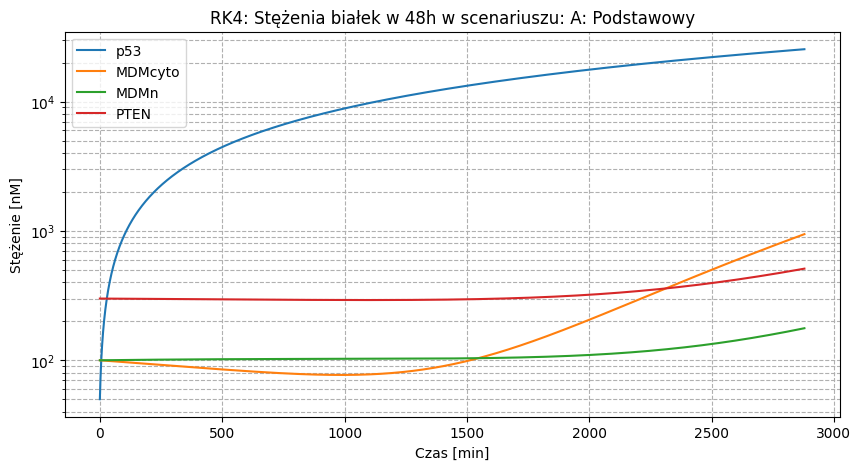

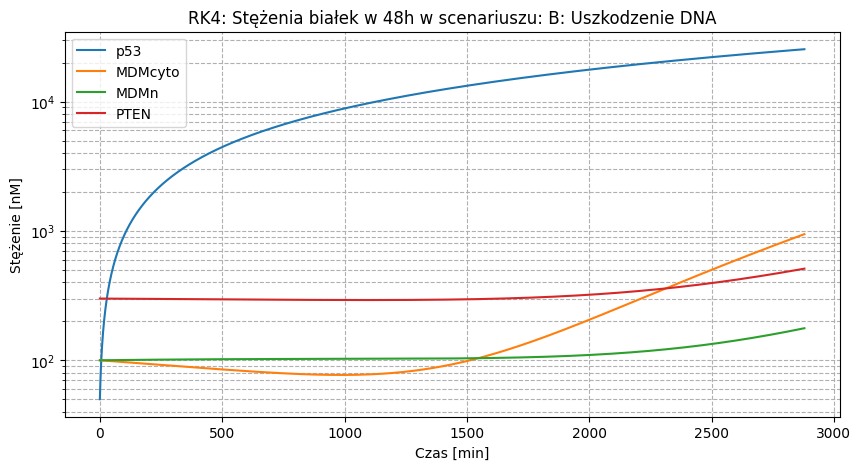

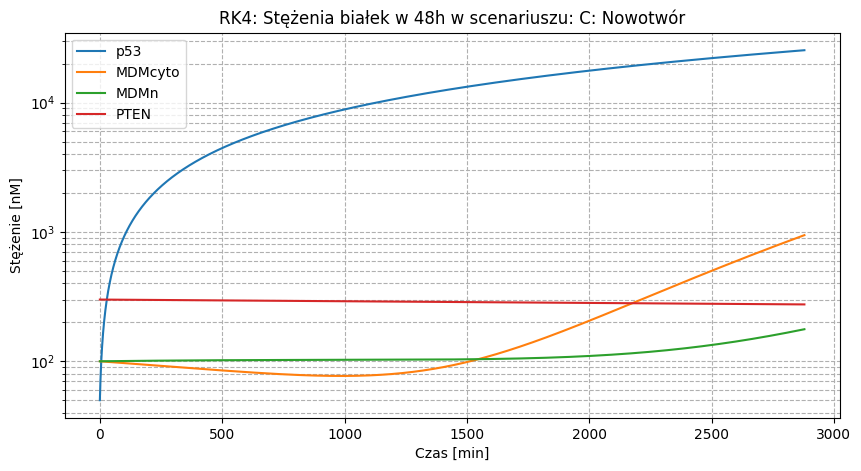

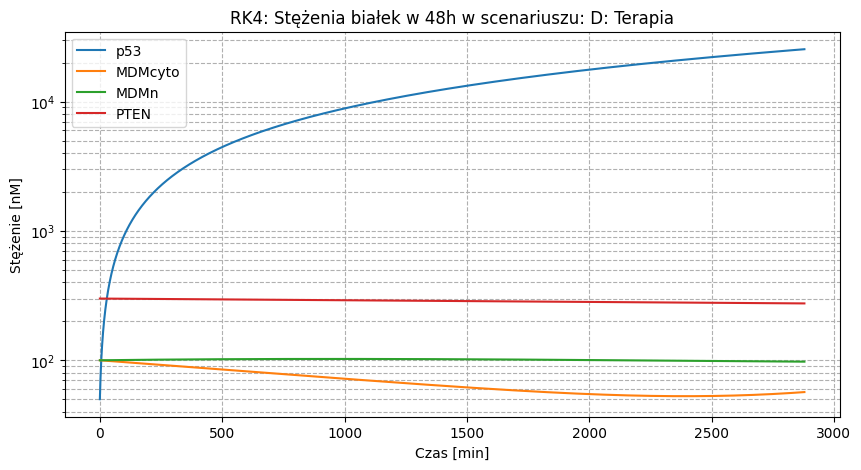

In [30]:
for scenario in scenarios:
    siRNA, pten_off, no_DNA_damage = conditions[scenario]
    p53, mdmcyto, mdmn, pten = p53_0, mdmcyto_0, mdmn_0, pten_0
    time_values = []
    p53_values = []
    mdmcyto_values = []
    mdmn_values = []
    pten_values = []
    for i in range(iterations):
        time = i * h
        time_values.append(time)
        p53_values.append(p53)
        mdmcyto_values.append(mdmcyto)
        mdmn_values.append(mdmn)
        pten_values.append(pten)
        p53, mdmcyto, mdmn, pten = RK4const(p53, mdmcyto, mdmn, pten, h, siRNA, pten_off, no_DNA_damage)
    plt.figure(figsize=(10,5))
    plt.plot(time_values, p53_values, label="p53")
    plt.plot(time_values, mdmcyto_values, label="MDMcyto")
    plt.plot(time_values, mdmn_values, label="MDMn")
    plt.plot(time_values, pten_values, label="PTEN")
    plt.xlabel("Czas [min]")
    plt.ylabel("Stężenie [nM]")
    plt.title(f"RK4: Stężenia białek w 48h w scenariuszu: {scenario}")
    plt.yscale("log")
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()

## 5. Wyniki symulacji: RK45 (adaptacyjny krok)

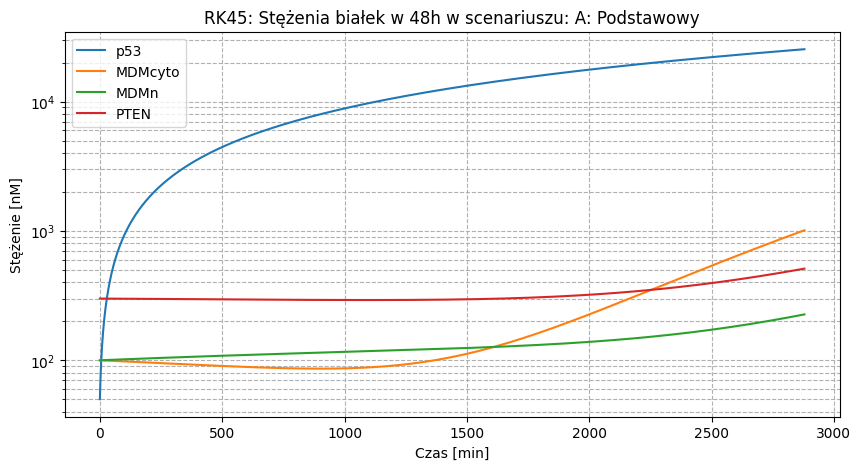

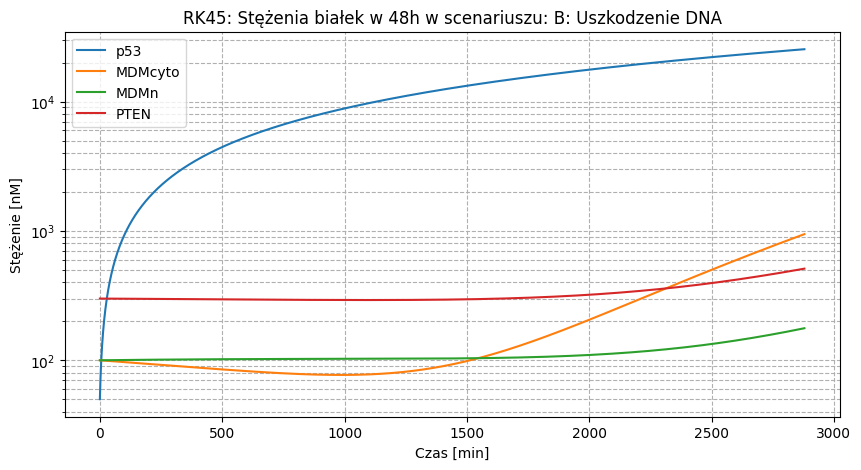

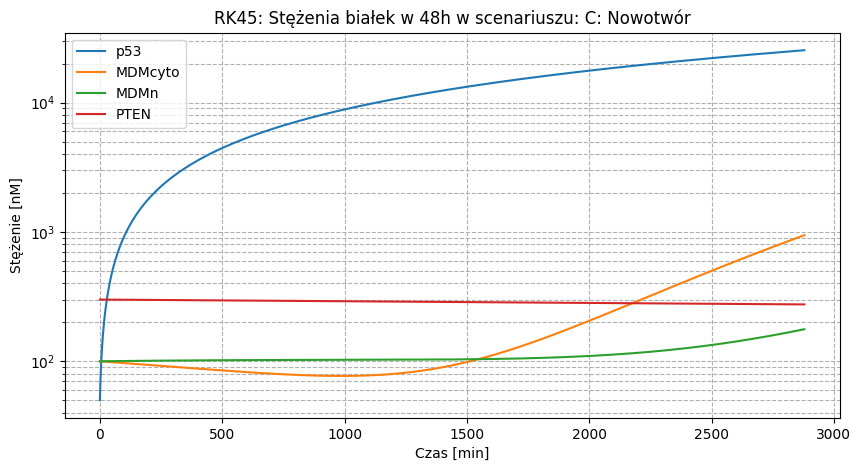

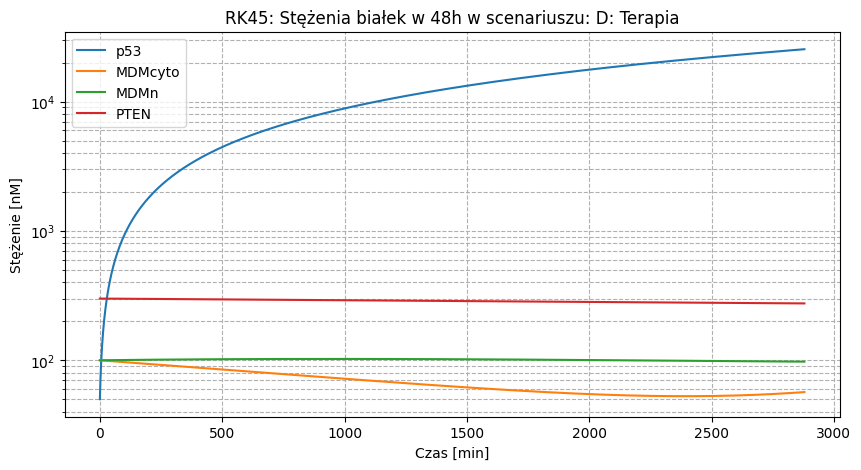

In [31]:
for scenario in scenarios:
    siRNA, pten_off, no_DNA_damage = conditions[scenario]
    p53, mdmcyto, mdmn, pten = p53_0, mdmcyto_0, mdmn_0, pten_0
    time_values = []
    p53_values = []
    mdmcyto_values = []
    mdmn_values = []
    pten_values = []
    for i in range(iterations):
        time = i * h
        time_values.append(time)
        p53_values.append(p53)
        mdmcyto_values.append(mdmcyto)
        mdmn_values.append(mdmn)
        pten_values.append(pten)
        p53, mdmcyto, mdmn, pten = RK45(p53, mdmcyto, mdmn, pten, h, siRNA=siRNA, pten_off=pten_off, no_DNA_damage=no_DNA_damage)
    plt.figure(figsize=(10,5))
    plt.plot(time_values, p53_values, label="p53")
    plt.plot(time_values, mdmcyto_values, label="MDMcyto")
    plt.plot(time_values, mdmn_values, label="MDMn")
    plt.plot(time_values, pten_values, label="PTEN")
    plt.xlabel("Czas [min]")
    plt.ylabel("Stężenie [nM]")
    plt.title(f"RK45: Stężenia białek w 48h w scenariuszu: {scenario}")
    plt.yscale("log")
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()

Dla porówniania pozwolę sobie skorzystać z rozwiązań gotowych oferowanych przez pakiet Scipy (niby nie mówił Profesor, że nie można korzystać z takich, ale uznaliśmy że nie wypada, więc to tylko kontorlnie):

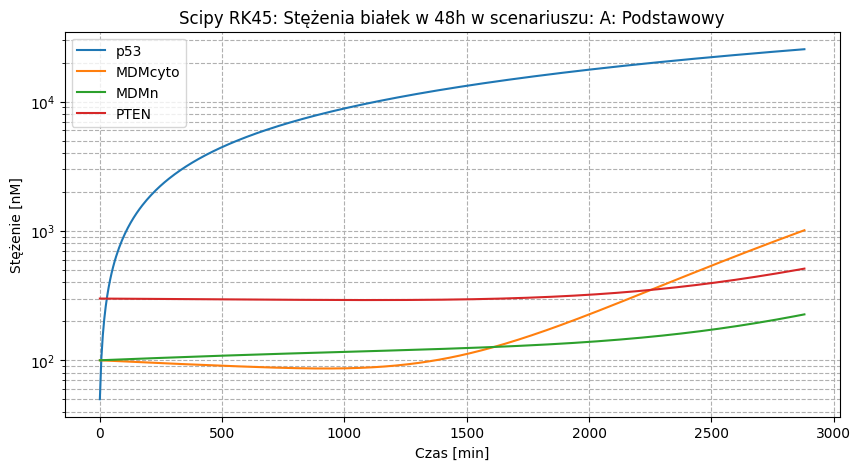

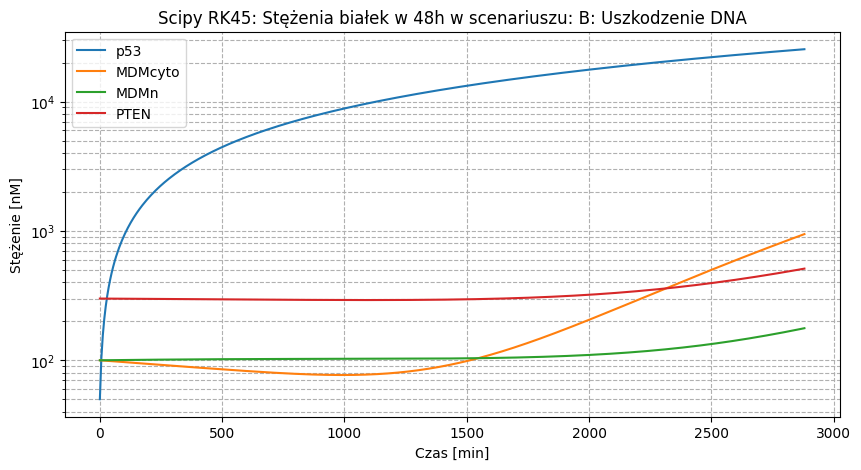

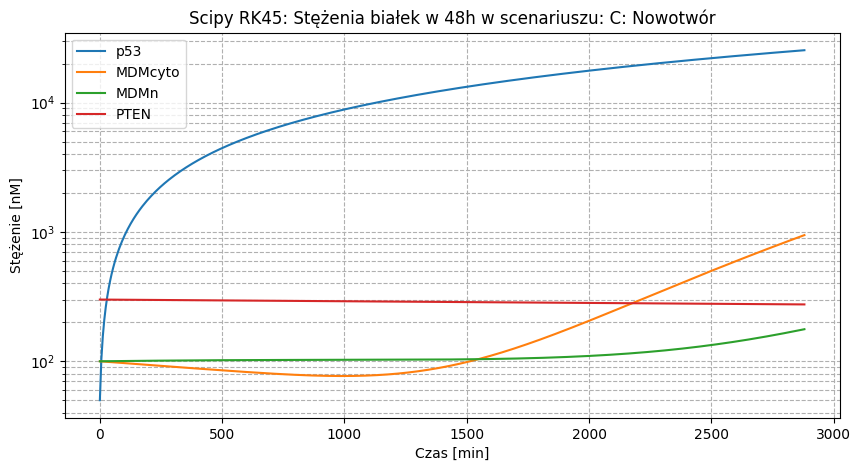

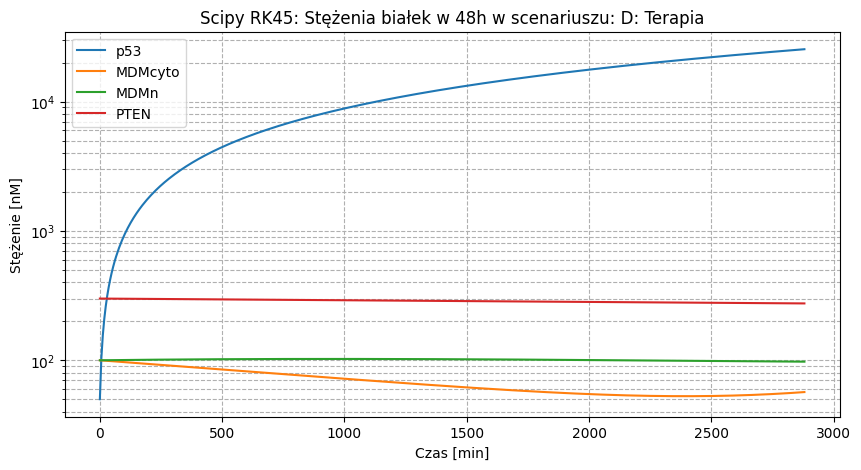

In [32]:
for scenario in scenarios:
    siRNA, pten_off, no_DNA_damage = conditions[scenario]
    sol = solve_ivp(
        model_ode, t_span, y0, method='RK45', t_eval=t_eval,
        args=(siRNA, pten_off, no_DNA_damage)
    )
    plt.figure(figsize=(10,5))
    plt.plot(sol.t, sol.y[0], label="p53")
    plt.plot(sol.t, sol.y[1], label="MDMcyto")
    plt.plot(sol.t, sol.y[2], label="MDMn")
    plt.plot(sol.t, sol.y[3], label="PTEN")
    plt.xlabel("Czas [min]")
    plt.ylabel("Stężenie [nM]")
    plt.title(f"Scipy RK45: Stężenia białek w 48h w scenariuszu: {scenario}")
    plt.yscale("log")
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()


## 6. Wnioski

1. Wszędzie za wyjątkiem scenariusza A symulowanego algorytmem z krokiem zmiennym widzimy spadek MDM 
2. Druga znaczna różnica w wynikach objawia się w scenariuszu D) Terapia – wyłączony PTEN, załączone uszkodzenia DNA i załączone siRNA.
3. Pozostałe różnice między scenariuszami dla przyjętych danych są kosmetyczne - warto by było gdyby profesor dał jakieś dane do wytestowania

---

## 7. Pełny kod programu

Kod źródłowy znajduje się w komórkach powyżej.